In [1]:
import cv2
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import pytesseract
import pyzbar.pyzbar as pyzbar

print(cv2.__version__)

4.5.1


2 19 24 29 45 0
1 33 23 40 43 0
. 45 24 49 28 0
0 54 20 64 41 0
5 66 19 78 40 0
. 81 21 84 24 0
0 88 17 100 37 0
5 103 16 112 36 0
2 126 13 135 33 0
~ 140 0 157 21 0

21.05.05


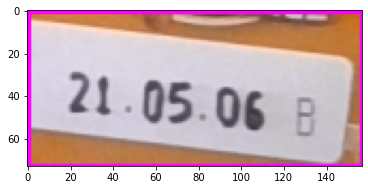

2 24 25 34 45 0
1 37 23 44 43 0
. 50 24 54 29 0
0 58 19 68 41 0
5 71 19 82 40 0
. 85 20 88 24 0
0 93 17 104 37 0
6 107 15 116 35 0
a 130 12 138 31 0
| 150 0 158 43 0

21.05.06


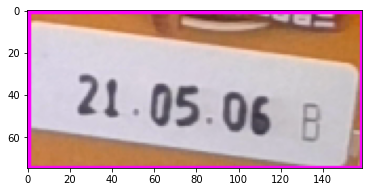

2 16 21 26 42 0
1 29 20 36 40 0
. 42 21 46 26 0
0 51 16 61 38 0
5 64 16 75 37 0
. 78 17 81 21 0
0 85 14 97 34 0
6 100 12 109 32 0
5 123 9 132 29 0
) 145 0 155 51 0

21.05.06


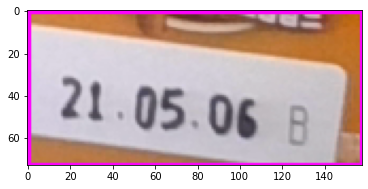

2 0 0 25 73 0
1 24 0 37 73 0
. 41 23 45 28 0
0 48 0 61 73 0
5 0 0 139 73 0
. 77 20 80 24 0
0 85 0 98 73 0
6 126 0 153 73 0
& 121 0 128 73 0
| 139 0 153 73 0

21.05.06


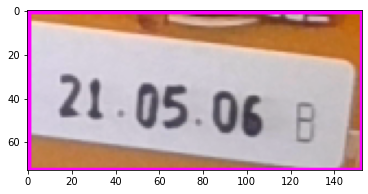

2 13 31 23 52 0
1 26 30 33 49 0
. 39 31 43 35 0
0 48 26 58 48 0
5 61 26 72 47 0
. 75 27 78 31 0
0 82 24 94 44 0
6 97 23 106 43 0
g 120 20 129 40 0
L 145 8 157 62 0

21.05.06


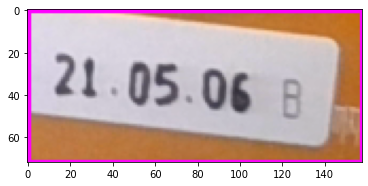

2 17 31 27 52 0
t 30 30 37 50 0
. 43 31 47 36 0
0 52 27 61 48 0
5 64 26 76 48 0
. 78 28 82 32 0
0 86 25 98 45 0
6 101 24 110 44 0
9 124 21 133 41 0

2t.05.06


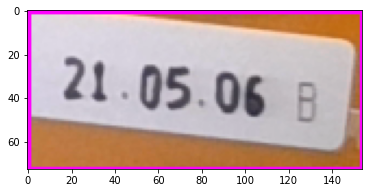

KeyboardInterrupt: 

In [2]:
cap = cv2.VideoCapture(0)
whT = 320

confThreshold = 0.5
nmsThreshold = 0.3

EDrac = [0,0,0,0,0]
x,y,w,h = 0,0,0,0
#EDBC= np.array()

classesFile = 'obj.names'   #내가 가지는 클래스 이름이 들어가있는 파일
classNames = []

with open(classesFile, 'rt') as f:
    classNames = f.read().rstrip('\n').split('\n')   #Expiration date 하나밖에 없어서 이거 하나
    
    
#print(classNames)
#print(len(classNames))

modelConfiguration= 'yolov3_ED.cfg' #모델 구조
modelWeights= 'yolov3_best.weights' #가중치

net = cv2.dnn.readNetFromDarknet(modelConfiguration,modelWeights) #다크넷 실행 모델구조랑 가중치 들고오겠다.
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV) #
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

#유통기한을 찾아서 네모 쳐주는 함수    
def findObjects(outputs,img):
    hT, wT, cT, = img.shape
    bbox= []
    classIds = []
    confs = []
    
    for output in outputs:
        for det in output:
            scores = det[5:]
            classId= np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                w,h = int(det[2]*wT), int(det[3]*hT)
                x,y = int((det[0]*wT)-w/2), int((det[1]*hT)-h/2)
                bbox.append([x,y,w,h])
                classIds.append(classId)
                confs.append(float(confidence))
    #print(len(bbox))
    indices = cv2.dnn.NMSBoxes(bbox,confs,confThreshold,nmsThreshold)
    #print(indices)
    #네모치는 곳
    for i in indices:
        i = i[0]
        box = bbox[i]
        x,y,w,h = box[0],box[1],box[2],box[3]
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.putText(img,f'{classNames[classIds[i]].upper()} {int(confs[i]*100)}%', (x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,255),2)
            
        #print(classNames[classIds[i]].upper())
        if indices == [[0]]:
            EDrac[0] = 1
            EDrac[1] = x
            EDrac[2] = y
            EDrac[3] = w
            EDrac[4] = h
        else:
            EDrac[0]= 0
        
        if EDrac[0] == 1:
            ED_pic = img[EDrac[2]:EDrac[2]+EDrac[4], EDrac[1]:EDrac[1]+EDrac[3]]
            plt.imshow(ED_pic)
            
            #1
            img_ori = ED_pic

            height, width, channel = img_ori.shape

            gray = cv2.cvtColor(img_ori,cv2.COLOR_BGR2GRAY)

            structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

            imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
            imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

            imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
            gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

            img_blurred = cv2.GaussianBlur(gray, ksize=(9, 9), sigmaX=0)

            img_thresh = cv2.adaptiveThreshold(
                img_blurred, 
                maxValue=255.0, 
                adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                thresholdType=cv2.THRESH_BINARY_INV, 
                blockSize=19, 
                C=6
            )


            print(pytesseract.image_to_boxes(img_thresh))

            #cv2.imshow('Result',img_ori)
            #cv2.waitKey(0)
            hImg,wImg,_ = img_ori.shape

            boxes = pytesseract.image_to_boxes(img_thresh)
            ED = ''
            for b in boxes.splitlines():
                #print(b)
                b= b.split(' ')
                #x,y,w,h = int(b[1]),int(b[2]),int(b[3]),int(b[4])
                #cv2.rectangle(img_ori,(x,hImg-y),(w,hImg-h),(0,0,255),1)
                #cv2.putText(img_ori,b[0],(x,hImg-y+25),cv2.FONT_HERSHEY_COMPLEX,1,(50,50,255),1)
                ED += b[0]
            if ED[0]=='2':
                print(ED[:8])


        


#---------------------------------------------------------------

while (cap.isOpened()):
    success, img = cap.read()
    
    if not success:
        continue

    blob = cv2.dnn.blobFromImage(img,1/255,(whT,whT),[0,0,0],1,crop=False)
    net.setInput(blob)

    layerNames = net.getLayerNames()
   # print(layerNames)
    outputNames = [layerNames[i[0]-1] for i in net.getUnconnectedOutLayers()]
    #print(outputNames) 
   # print(net.getUnconnectedOutLayers())

    outputs = net.forward(outputNames)

    findObjects(outputs,img)

    
    plt.show()
  #  print(EDrac)       

    cv2.imshow('123',img)
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
    elif key == ord('s'):
        i += 1
        cv2.imwrite('c_%03d.jpg' % i, img)
        
cap.release()
cv2.destroyAllWindows()
